# Mooomentums
Mooom is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [88]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [89]:
df = pd.read_parquet("compustat_ibes_raw_alpha.1.parquet")

In [90]:
df.head()

cshoc  prccd          mcap  mcap_pctl country  \
gvkey  date                                                             
001166 1999-12-31  39601840.0  23.50  9.306432e+08   0.775869     NLD   
       2000-01-31  39601840.0  25.80  1.021727e+09   0.800211     NLD   
       2000-02-29  41496672.0  32.25  1.338268e+09   0.803457     NLD   
       2000-03-31  43534629.0  31.50  1.371341e+09   0.803783     NLD   
       2000-04-30  47784629.0  36.35  1.736971e+09   0.829851     NLD   

                  industry                   classification      act      att  \
gvkey  date                                                                     
001166 1999-12-31     INDL  SPECIAL INDUSTRY MACHINERY, NEC  292.101  425.035   
       2000-01-31     INDL  SPECIAL INDUSTRY MACHINERY, NEC  292.101  425.035   
       2000-02-29     INDL  SPECIAL INDUSTRY MACHINERY, NEC  292.101  425.035   
       2000-03-31     INDL  SPECIAL INDUSTRY MACHINERY, NEC  292.101  425.035   
       2000-04-30     INDL  SPECIAL INDUSTRY MACHINERY, NEC  292.101  425.035   

                        ap    capx     ceq      ch     che    chee     cogs  \
gvkey  date                                                                   
001166 1999-12-31  108.922  30.587  65.552  14.153  19.862  14.153  219.998   
       2000-01-31  108.922  30.587  65.552  14.153  19.862  14.153  219.998   
       2000-02-29  108.922  30.587  65.552  14.153  19.862  14.153  219.998   
       2000-03-31  108.922  30.587  65.552  14.153  19.862  14.153  219.998   
       2000-04-30  108.922  30.587  65.552  14.153  19.862  14.153  219.998   

                       dlc  dltis  dltr   dltt      dp     dv  dvc  dvt  \
gvkey  date                                                               
001166 1999-12-31  111.896    0.0   0.0  7.997  24.487  8.384  0.0  0.0   
       2000-01-31  111.896    0.0   0.0  7.997  24.487  8.384  0.0  0.0   
       2000-02-29  111.896    0.0   0.0  7.997  24.487  8.384  0.0  0.0   
       2000-03-31  111.896    0.0   0.0  7.997  24.487  8.384  0.0  0.0   
       2000-04-30  111.896    0.0   0.0  7.997  24.487  8.384  0.0  0.0   

                    dlcch    ebit  ebitda   fincf   gdwl    icapt  intan  \
gvkey  date                                                                
001166 1999-12-31 -15.372  39.355  63.842 -26.298  5.758  143.679  5.758   
       2000-01-31 -15.372  39.355  63.842 -26.298  5.758  143.679  5.758   
       2000-02-29 -15.372  39.355  63.842 -26.298  5.758  143.679  5.758   
       2000-03-31 -15.372  39.355  63.842 -26.298  5.758  143.679  5.758   
       2000-04-30 -15.372  39.355  63.842 -26.298  5.758  143.679  5.758   

                     invt  ivaeq  ivao   ivncf   ivst      lct      ltt  \
gvkey  date                                                               
001166 1999-12-31  107.28    0.0   0.0 -26.794  5.709  277.866  289.353   
       2000-01-31  107.28    0.0   0.0 -26.794  5.709  277.866  289.353   
       2000-02-29  107.28    0.0   0.0 -26.794  5.709  277.866  289.353   
       2000-03-31  107.28    0.0   0.0 -26.794  5.709  277.866  289.353   
       2000-04-30  107.28    0.0   0.0 -26.794  5.709  277.866  289.353   

                     mib   nicon   oancf      pi    ppegt    ppent  pstk  \
gvkey  date                                                                
001166 1999-12-31  70.13  11.099  46.902  30.747  276.119  127.176   0.0   
       2000-01-31  70.13  11.099  46.902  30.747  276.119  127.176   0.0   
       2000-02-29  70.13  11.099  46.902  30.747  276.119  127.176   0.0   
       2000-03-31  70.13  11.099  46.902  30.747  276.119  127.176   0.0   
       2000-04-30  70.13  11.099  46.902  30.747  276.119  127.176   0.0   

                   prstkc     rect     revt     seq   sstk  teq    txp   xint  \
gvkey  date                                                                     
001166 1999-12-31     0.0  149.115  414.495  65.552  0.496  0.0  3.887  8.608   
       2000-01-31     0.0  14

In [91]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [92]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    return df

In [93]:
def computeRSI(data, time_window):
    diff = data.diff(1).dropna()  # diff in one field(one day)

    # this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]

    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()

    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [110]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df
    df_mom = df_mom['low high close prccd mcap'.split()]
    df_mom = df_mom.loc[df.prccd > 10]
    df_mom = df_mom.loc[df.mcap > 500000000]
    times = [3, 4, 5, 10, 20, 40]
    
    df = df_mom
    df["return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(1))
    for time in times:
        df[f"RET {time}"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(time - 1))
        df[f"STD {time}"] = df['return'].groupby("gvkey").transform(lambda x: x.rolling(time).std())
        df[f"EMA {time}"] = df.close.groupby("gvkey").transform(lambda x: x / x.ewm(span=time, adjust=False).mean() -1 )
        df[f"SH {time}"] = df['return'].groupby("gvkey").transform(lambda x: x.rolling(time).mean() / x.rolling(time).std())
        df[f"QT {time}"] = df['close'].groupby("gvkey").transform(lambda x: x.rolling(time).quantile(0.75) / x)
        df[f"SCOSC {time}"] = df['close'].groupby("gvkey").transform(lambda x: (x - x.rolling(time).min()) 
                                                                     / (x.rolling(time).max() - x.rolling(time).min()))

    df['high'] = df['high'] / df['close'] - 1
    df['low'] = df['low'] / df['close'] - 1
    
    df_mom = df
    df_mom["return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(3))
    df_mom["targ_return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(3).shift(-3))

    df_mom["y1"] = np.where(df_mom['targ_return'] > 0.05, 1, 0)
    df_mom["y2"] = np.where(df_mom['targ_return'] < -0.05, -1, 0)
    df_mom["y"] = df_mom["y2"] + df_mom["y1"]
    
    df_mom = df_mom.drop('y2',axis=1)
    df_mom = df_mom.drop('y1',axis=1)
    df_mom = df_mom.drop('targ_return',axis=1)
    df_mom = df_mom.drop('prccd',axis=1)
    df_mom = df_mom.drop('close',axis=1)
    df_mom = df_mom.drop('mcap',axis=1)
    return df_mom.dropna()

In [111]:
df_mom = mooom(df)

In [112]:
df_backup = df_mom.copy()

In [113]:
# df_mom = df_backup.copy()

In [114]:
df_mom.head()

low      high    return     RET 3     STD 3     EMA 3  \
gvkey  date                                                                     
001166 2003-07-31 -0.147281  0.135582  0.188062  0.128982  0.046099  0.064181   
       2003-08-31 -0.219601  0.075620  0.284382  0.261832  0.062572  0.095293   
       2003-09-30 -0.021961  0.341176 -0.026718 -0.122505  0.203771 -0.084112   
       2003-10-31 -0.157965  0.054217  0.028217 -0.096189  0.222001  0.035310   
       2003-11-30 -0.053797  0.069620 -0.044162  0.239216  0.206287  0.045303   

                       SH 3      QT 3   SCOSC 3     RET 4     STD 4     EMA 4  \
gvkey  date                                                                     
001166 2003-07-31  1.296925  0.950791  1.000000  0.188062  0.060635  0.078164   
       2003-08-31  1.409997  0.939504  1.000000  0.284382  0.054150  0.124645   
       2003-09-30  0.029660  1.218039  0.000000 -0.026718  0.166483 -0.083972   
       2003-10-31  0.121224  1.053213  0.579365  0.028217  0.185870  0.042767   
       2003-11-30  0.001055  0.972785  1.000000 -0.044162  0.181910  0.059240   

                       SH 4      QT 4   SCOSC 4     RET 5     STD 5     EMA 5  \
gvkey  date                                                                     
001166 2003-07-31  1.378017  0.926187  1.000000  0.372049  0.096967  0.081172   
       2003-08-31  1.463553  0.909256  1.000000  0.351594  0.057815  0.142410   
       2003-09-30  0.054063  1.178824  0.000000 -0.009324  0.145475 -0.082488   
       2003-10-31  0.255416  1.026606  0.579365  0.140458  0.161511  0.048849   
       2003-11-30  0.190066  1.011551  0.806878  0.087405  0.161031  0.070258   

                       SH 5      QT 5   SCOSC 5    RET 10    STD 10    EMA 10  \
gvkey  date                                                                     
001166 2003-07-31  0.485734  0.901583  1.000000 -0.004795  0.137098  0.018059   
       2003-08-31  1.632340  0.879008  1.000000  0.271538  0.129652  0.125811   
       2003-09-30  0.121440  1.139608  0.000000  0.003937  0.147187 -0.110342   
       2003-10-31  0.257278  1.000000  0.579365  0.002012  0.155241  0.034482   
       2003-11-30  0.307344  1.000000  0.806878  0.344681  0.147217  0.075641   

                      SH 10     QT 10  SCOSC 10    RET 20    STD 20    EMA 20  \
gvkey  date                                                                     
001166 2003-07-31 -0.087456  0.975396  0.912037  0.135156  0.196410 -0.111728   
       2003-08-31  0.156232  0.857381  1.000000 -0.057045  0.167772  0.009526   
       2003-09-30  0.056712  1.111569  0.363636 -0.250000  0.156177 -0.204561   
       2003-10-31  0.179279  0.991633  0.732323 -0.313103  0.160864 -0.061863   
       2003-11-30  0.109948  0.939082  0.877104 -0.254717  0.148161 -0.007117   

                      SH 20     QT 20  SCOSC 20    RET 40    STD 40    EMA 40  \
gvkey  date                                                                     
001166 2003-07-31 -0.019038  1.456469  0.206175 -0.436822  0.230274 -0.225815   
       2003-08-31  0.153388  1.280248  0.310832 -0.487442  0.230481 -0.114098   
       2003-09-30 -0.026740  1.659804  0.113030 -0.595238  0.230284 -0.305961   
       2003-10-31  0.036825  1.416499  0.227630 -0.588996  0.231817 -0.179272   
       2003-11-30 -0.034885  1.184810  0.272632 -0.457045  0.230737 -0.126402   

                      SH 40     QT 40  SCOSC 40  y  
gvkey  date                                         
001166 2003-07-31  0.054493  1.789401  0.152950  0  
       2003-08-31  0.056169  1.572898  0.230590  0  
       2003-09-30  0.004251  2.014706  0.083851  1  
       2003-10-31  0.025255  1.671352  0.168866  1  
       2003-11-30  0.014928  1.500158  0.272632  1

In [115]:
df_mom.y.value_counts()

 1    18388
 0    17745
-1    12144
Name: y, dtype: int64

## Multi Classification

In [116]:
def threshold(y):
    return y

## Portfolio Return

In [117]:
df_train = df_mom.xs(slice("2002-01-01", "2013-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2013-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test= threshold(df_test.y)
xgb_clf = XGBClassifier(n_jobs=-1, class_weight='balanced')
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", 'hold', "buy"]))

[18:09:47] WARNING: ../src/learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy on training set: 0.7673467018775937
Accuracy on test set: 0.38801191362620996
              precision    recall  f1-score   support

        sell       0.22      0.16      0.18      2867
        hold       0.47      0.41      0.44      5608
         buy       0.38      0.50      0.43      4955

    accuracy                           0.39     13430
   macro avg       0.36      0.36      0.35     13430
weighted avg       0.38      0.39      0.38     13430



In [118]:
def frame_to_signals(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    short_array = -1 * estimator.predict_proba(X)[:, 0]
    long_array = estimator.predict_proba(X)[:, -1]
    short_signal = pd.Series(short_array, frame.index)
    long_signal = pd.Series(long_array, frame.index)
    return short_signal, long_signal

In [119]:
def noise_to_belief(signal, n):
    return signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(n))

In [120]:
def monthly_to_daily(signal, months, weight):
    daily_signals = []
    for index, value in signal.iteritems():
        gvkey = index[0]
        predict_date = pd.to_datetime(index[1])
        start = predict_date + DateOffset(days=1)
        end = predict_date + DateOffset(months=months)
        date_range = pd.date_range(start, end, freq="D", name="date")
        daily_idx = pd.MultiIndex.from_tuples([(gvkey, date) for date in date_range], names=["gvkey", "date"])
        if weight == "equal":
            daily_signal = pd.Series(np.sign(value), daily_idx)
        elif weight == "value":
            daily_signal = pd.Series(value, daily_idx)
        daily_signals.append(daily_signal)
    return pd.concat(daily_signals)

In [121]:
def signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal"):
    short_belief = noise_to_belief(short_signal, n)
    long_belief = noise_to_belief(long_signal, n)
    short_daily = monthly_to_daily(short_belief, months, weight)
    long_daily = monthly_to_daily(long_belief, months, weight)
    short_position = short_daily.groupby(["gvkey", "date"]).agg("sum")
    long_position = long_daily.groupby(["gvkey", "date"]).agg("sum")
    neutral_position = pd.concat([short_position, long_position]).groupby(["gvkey", "date"]).agg("sum")
    return short_position, long_position, neutral_position

In [122]:
def position_to_margin(data, position, tx=-0.002, method="percent"):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, tx, 0)
    if method == "log":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-1) / x)).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = margin.droplevel("gvkey").resample("D").sum().cumsum()
    elif method == "percent":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = (margin.droplevel("gvkey").resample("D").mean() + 1).cumprod()
    return margin

In [123]:
data = pd.read_parquet("daily_price_backtest.parquet")
data = data[data.index.get_level_values("gvkey") != '249103']
short_signal, long_signal = frame_to_signals(df_test, xgb_clf)
short_position, long_position, neutral_position = signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal")

<AxesSubplot:xlabel='date'>

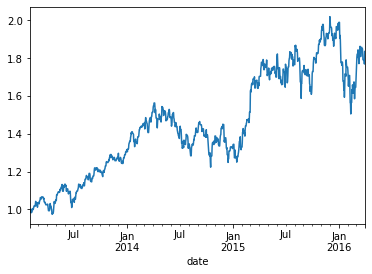

In [124]:
margin = position_to_margin(data, long_position, method="percent")
margin.plot()

<AxesSubplot:xlabel='date'>

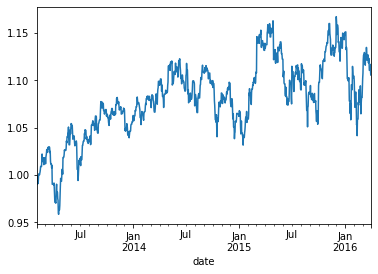

In [125]:
margin = position_to_margin(data, neutral_position, method="percent")
margin.plot()

<AxesSubplot:xlabel='date'>

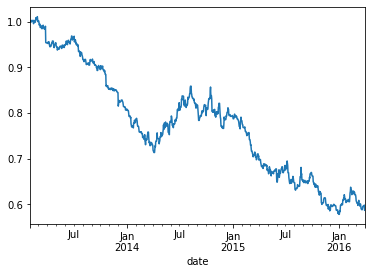

In [126]:
margin = position_to_margin(data, short_position, method="percent")
margin.plot()